In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
events = pd.read_csv('events_sample8.tar.gz', sep='\t', encoding='utf-8', error_bad_lines=False, compression='gzip', dtype=str, parse_dates=['oper_date_time', 'oper_date_time_msk', 'oper_date_time_local'], names=['bar_code', 'oper_date_time', 'oper_date_time_local', 'oper_date_time_msk', 'oper_type', 'oper_attr', 'oper_type_local', 'oper_type_name_local', 'index_oper', 'country_oper', 'index_next', 'type_of_operand1', 'id_of_operand1', 'type_of_operand2', 'id_of_operand2', 'date_processed', 'oper_before_link', 'seal_num', 'entity_type', 'entity_type_loc_id', 'entity_type_loc_name', 'index_to', 'index_from', 'mass', 'document_form'])

In [5]:
addrs = pd.read_csv('addrs_sample8.tar.gz', sep='\t', dtype=str, encoding='utf-8', parse_dates=['create_date_time'], error_bad_lines=False, compression='gzip', names=['bar_code', 'create_date_time', 'index_from', 'index_to', 'trans_type', 'mail_type', 'mail_ctg', 'mail_rank', 'send_ctg', 'post_mark', 'sndr', 'rcpn', 'recv_address.index', 'recv_address.address.place', 'recv_address.address.street', 'recv_address.address.house.value', 'recv_address.address.house.letter', 'recv_address.address.house.slash', 'recv_address.address.house.corpus', 'recv_address.address.house.building', 'recv_address.address.house.room', 'recv_phone'])

In [23]:
delivered = (events['oper_type'] == '2')
returned = events['oper_type'].isin(['3','12'])
lost = events['oper_type'].isin(['7','15','6'])
events['status'] = 0 # unknown
events.loc[delivered,'status'] = 1 # delivered
events.loc[returned,'status'] = 2 # returned
events.loc[lost,'status'] = 3 # lost

<Container object of 24 artists>

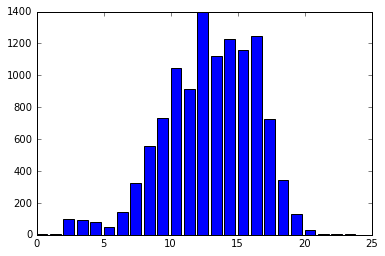

In [24]:
counts = events[events['oper_type'] == '2']['oper_date_time_msk'].dt.hour.value_counts(sort=False)
plt.bar(counts.index,counts)

In [25]:
events['status'].value_counts()

0    691283
1     11444
2      9909
3      1597
Name: status, dtype: int64

In [26]:
clean_addrs = addrs.drop(['sndr', 'rcpn', 'recv_phone', 'recv_address.address.house.room', 'recv_address.address.house.value', 'recv_address.address.street', 'recv_address.address.place', 'index_from', 'index_to', 'recv_address.address.house.letter', 'recv_address.address.house.slash', 'recv_address.address.house.corpus', 'recv_address.address.house.building'], axis=1).fillna(0)

In [27]:
clean_addrs['trans_type'] = clean_addrs['trans_type'].astype(np.int32)
clean_addrs['mail_type'] = clean_addrs['mail_type'].astype(np.int32)
clean_addrs['mail_ctg'] = clean_addrs['mail_ctg'].astype(np.int32)
clean_addrs['mail_rank'] = clean_addrs['mail_rank'].astype(np.int32)
clean_addrs['send_ctg'] = clean_addrs['send_ctg'].astype(np.int32)
clean_addrs['post_mark'] = clean_addrs['post_mark'].astype(np.int32)
clean_addrs['recv_address.index'] = clean_addrs['recv_address.index'].astype(np.int32)
clean_addrs = clean_addrs.add_prefix('info_')

In [28]:
clean_events = events[['bar_code', 'oper_date_time', 'oper_date_time_local', 'oper_date_time_msk', 'index_oper', 'entity_type', 'entity_type_loc_id', 'mass', 'status']]

In [30]:
clean_events_num = clean_events[clean_events['status'].isin([1,2,3])].fillna(0)

In [31]:
clean_events_num['index_oper'] = clean_events_num['index_oper'].astype(np.int32)
clean_events_num['entity_type'] = clean_events_num['entity_type'].astype(np.int32)
clean_events_num['entity_type_loc_id'] = clean_events_num['entity_type_loc_id'].astype(np.int32)
clean_events_num['mass'] = clean_events_num['mass'].astype(np.int32)

In [45]:
df = clean_events_num.join(clean_addrs, )

In [46]:
df = df[df['oper_date_time'].dt.year >= 2016]

In [49]:
df = df.drop(['bar_code', 'oper_date_time', 'oper_date_time_local', 'oper_date_time_msk', 'info_bar_code', 'info_create_date_time'], axis=1)

ValueError: labels ['bar_code' 'oper_date_time' 'oper_date_time_local' 'oper_date_time_msk'
 'info_bar_code' 'info_create_date_time'] not contained in axis

In [50]:
from sklearn.cross_validation import train_test_split
import xgboost as xgb

In [51]:
X = df.drop(['status'], axis=1)
Y = df['status']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [53]:
model = xgb.XGBClassifier()

In [54]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [55]:
y_pred = model.predict(X_test)

In [56]:
predictions = [round(value) for value in y_pred]

In [57]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)

NameError: name 'accuracy_score' is not defined